In [41]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from datetime import datetime

In [42]:
df_fb_metrics = pd.read_csv('dataset_Facebook.csv',sep=';')

In [43]:
print(df_fb_metrics.info())
df_fb_metrics.replace(r'^\s*$', np.nan, regex=True, inplace = True)
df_fb_metrics.replace('?', np.nan, inplace = True)
print(df_fb_metrics.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
Page total likes                                                       500 non-null int64
Type                                                                   500 non-null object
Category                                                               500 non-null int64
Post Month                                                             500 non-null int64
Post Weekday                                                           500 non-null int64
Post Hour                                                              500 non-null int64
Paid                                                                   499 non-null float64
Lifetime Post Total Reach                                              500 non-null int64
Lifetime Post Total Impressions                                        500 non-null int64
Lifetime Engaged Users                                                 500 non-nul

In [44]:
#Since we are going to consider Total Interactions as the output variable (being the sum of Comment , Like, Share) 
#we can drop Comment , Like, Share and the null values associated with them.
individual_interaction_components = ['comment','like','share']
df_fb_metrics = df_fb_metrics.drop(columns=individual_interaction_components, axis=1)
df_fb_metrics.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,393


In [45]:
#We now have a categorical input variable Type.
df_fb_metrics["Type"].value_counts()

Photo     426
Status     45
Link       22
Video       7
Name: Type, dtype: int64

In [46]:
#With just 4 different types of values we can plan to use OneHotEncoding which would add 4 new columns to our dataframe 
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(df_fb_metrics["Type"])
encoded_df = pd.DataFrame(lb_results, columns=lb_style.classes_)
df_fb_metrics = pd.concat([df_fb_metrics,encoded_df], axis=1) 
cols = list(df_fb_metrics)
cols.insert(1, cols.pop(cols.index('Link')))
cols.insert(2, cols.pop(cols.index('Photo')))
cols.insert(3, cols.pop(cols.index('Status')))
cols.insert(4, cols.pop(cols.index('Video')))
df_fb_metrics = df_fb_metrics.loc[:, cols]
df_fb_metrics = df_fb_metrics.drop(columns=['Type'],axis=1)
df_fb_metrics.head()

,Page total likes,Link,Photo,Status,Video,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,Total Interactions
0,139441,0,1,0,0,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,100
1,139441,0,0,1,0,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,164
2,139441,0,1,0,0,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,80
3,139441,0,1,0,0,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,1777
4,139441,0,1,0,0,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,393


In [47]:
#We now have a categorical input variable Type.
df_fb_metrics["Paid"].value_counts()

0.0    360
1.0    139
Name: Paid, dtype: int64

In [48]:
df_fb_metrics[df_fb_metrics.isna().any(axis=1)]

,Page total likes,Link,Photo,Status,Video,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,Total Interactions
499,81370,0,1,0,0,2,1,4,4,NaN,4188,7292,564,524,743,3861,2200,316,119


In [49]:
#Fill missing value with most common value
df_fb_metrics = df_fb_metrics.apply(lambda x: x.fillna(x.value_counts().index[0]))
df_fb_metrics.shape

(500, 19)

In [50]:
#Removing Outliers remove records that are above the 90th percentile
outlier_cut_off_value = np.percentile(df_fb_metrics['Total Interactions'],90)
df_fb_metrics = df_fb_metrics[df_fb_metrics['Total Interactions']<outlier_cut_off_value]
df_fb_metrics.shape

(450, 19)

In [51]:
#Preparing the training and testing dataset.
X_train, X_test, y_train, y_test = train_test_split(df_fb_metrics.iloc[:, 0:18].values, df_fb_metrics.iloc[:, 18].values, test_size=0.33, random_state=0)
#Standardising the data set
scaler = StandardScaler()
scaler.fit(X_train)
x_train_scaled = scaler.transform(X_train)
x_test_scaled = scaler.transform(X_test)

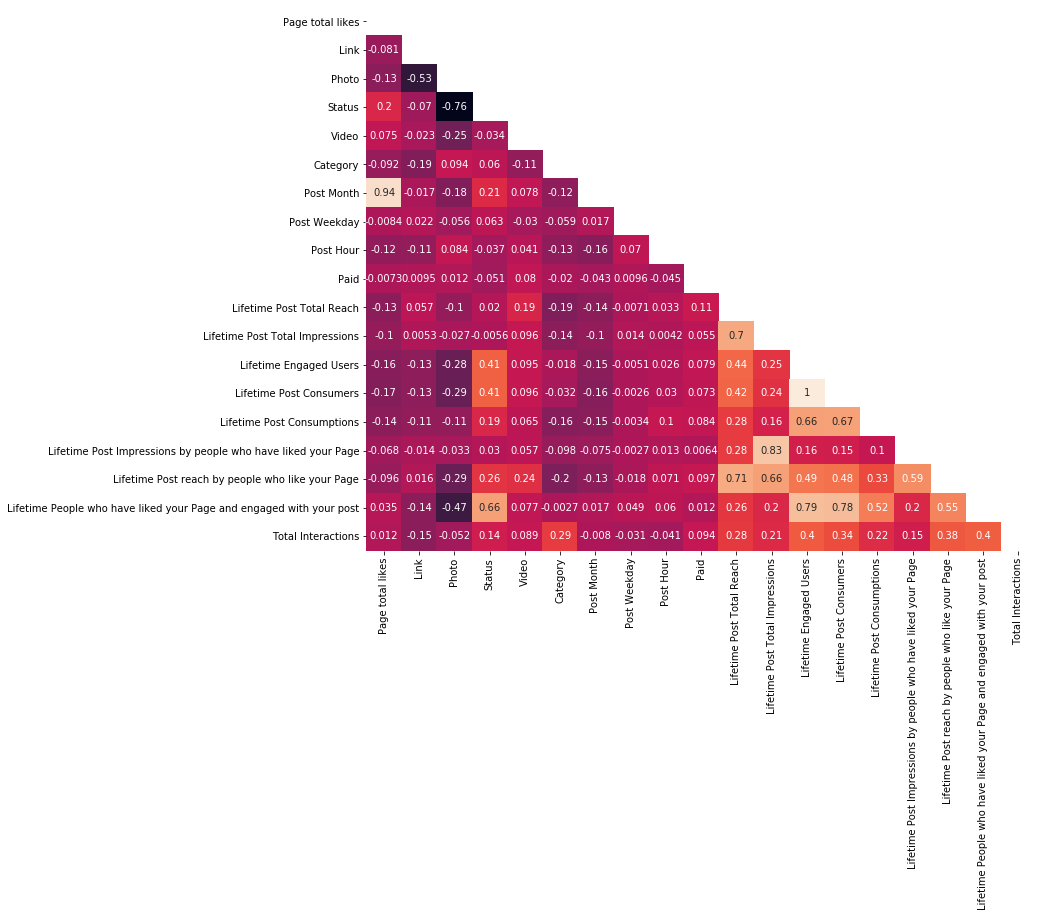

In [52]:
plt.figure(figsize=(12,10))
df_fb_metrics_corr = df_fb_metrics.corr()
mask = np.zeros_like(df_fb_metrics_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_fb_metrics_corr,annot=True,cbar=False, mask=mask)

In [53]:
#Running the dataset across various regressors

In [62]:
def svr_param_selection(X, y, X_test, y_test, nfolds):
    Kernels = ['linear', 'poly', 'rbf']
    Cs = [0.001, 0.01, 0.1, 1]
    Gammas = [0.001, 0.01, 0.1]
    param_grid = {'kernel':Kernels, 'C': Cs, 'gamma' : Gammas}
    grid_search = GridSearchCV(SVR(), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('SVR MSE Score for training data: '+str(grid_search.best_score_))
    print('SVR With Parameters: '+str(grid_search.best_params_))    
    print('SVR coefficient of determination R^2 on test data: '+str(grid_search.best_estimator_.score(X_test, y_test)))
    y_pred = grid_search.best_estimator_.predict(X_test)
    print('MSE for SVR on test set: '+str(mean_squared_error(y_test, y_pred)))

In [63]:
def random_forest_regressor_param_selection(X, y, X_test, y_test, nfolds):
    Estimators = np.arange(1,100,15)
    Max_features = ['auto', 'sqrt']
    Min_samples_leafs = np.linspace(0.01, 0.05, 5, endpoint=True)
    param_grid = {'n_estimators': Estimators, 'max_features': Max_features, 'min_samples_leaf': Min_samples_leafs}
    grid_search = GridSearchCV(RandomForestRegressor(random_state=0), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('RandomForestRegressor MSE Score for training data: '+str(grid_search.best_score_))
    print('RandomForestRegressor With Parameters: '+str(grid_search.best_params_))    
    print('Random Forest coefficient of determination R^2 on test data: '+str(grid_search.best_estimator_.score(X_test, y_test)))
    y_pred = grid_search.best_estimator_.predict(X_test)
    print('MSE for Random Forest Regressor on test set: '+str(mean_squared_error(y_test, y_pred)))

In [64]:
def decision_tree_regressor_param_selection(X, y, X_test, y_test, nfolds):
    Max_features = ['auto', 'sqrt']
    Min_samples_leafs = np.linspace(0.01, 0.05, 5, endpoint=True)
    param_grid = {'max_features': Max_features, 'min_samples_leaf': Min_samples_leafs}
    grid_search = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('DecisionTreeRegressor MSE Score for training data: '+str(grid_search.best_score_))
    print('DecisionTreeRegressor With Parameters: '+str(grid_search.best_params_)) 
    print('Decision Tree coefficient of determination R^2 on test data: '+str(grid_search.best_estimator_.score(X_test, y_test)))
    y_pred = grid_search.best_estimator_.predict(X_test)
    print('MSE for Decision Tree Regressor on test set: '+str(mean_squared_error(y_test, y_pred)))

In [65]:
def ada_boost_regressor_param_selection(X, y, X_test, y_test, nfolds):
    Estimators = np.arange(1,100,15)
    Learning_rates = [0.01,0.05,0.1,0.3]
    Losses = ['linear', 'square', 'exponential']
    param_grid = {'n_estimators': Estimators, 'learning_rate': Learning_rates, 'loss': Losses}
    grid_search = GridSearchCV(AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),random_state=0), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('AdaBoostRegressor MSE Score for training data: '+str(grid_search.best_score_))
    print('AdaBoostRegressor With Parameters:'+str(grid_search.best_params_))
    print('AdaBoost Regressor coefficient of determination R^2 on test data: '+str(grid_search.best_estimator_.score(X_test, y_test)))
    y_pred = grid_search.best_estimator_.predict(X_test)
    print('MSE for AdaBoost Regressor on test set: '+str(mean_squared_error(y_test, y_pred)))

In [66]:
def gaussian_regressor_param_selection(X, y, X_test, y_test, nfolds):
    kernel_rbf = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")
    kernel_rq = ConstantKernel(1.0, constant_value_bounds="fixed") * RationalQuadratic(alpha=0.1, length_scale=1)
    kernel_expsine = ConstantKernel(1.0, constant_value_bounds="fixed") * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))
    Kernels = [kernel_rbf, kernel_rq, kernel_expsine]
    param_grid = {'kernel': Kernels}
    grid_search = GridSearchCV(GaussianProcessRegressor(random_state=0), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('GaussianRegressor MSE Score for training data: '+str(grid_search.best_score_))
    print('GaussianRegressor With Parameters:'+str(grid_search.best_params_)) 
    print('Gaussian Regressor coefficient of determination R^2 on test data: '+str(grid_search.best_estimator_.score(X_test, y_test)))
    y_pred = grid_search.best_estimator_.predict(X_test)
    print('MSE for Gaussian Regressor on test set: '+str(mean_squared_error(y_test, y_pred)))

In [67]:
def linear_regressor_param_selection(X, y, X_test, y_test, nfolds):
    param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    grid_search = GridSearchCV(LinearRegression(), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('LinearRegressor MSE Score for training data: '+str(grid_search.best_score_))
    print('LinearRegressor With Parameters:'+str(grid_search.best_params_))  
    print('Linear Regressor coefficient of determination R^2 on test data: '+str(grid_search.best_estimator_.score(X_test, y_test)))
    y_pred = grid_search.best_estimator_.predict(X_test)
    print('MSE for LinearRegressor on test set: '+str(mean_squared_error(y_test, y_pred)))

In [68]:
def neural_network_regressor_param_selection(X, y, X_test, y_test, nfolds):
    Hidden_Layer_Sizes = [1, 5, (5,5), 10, (10,5)]
    Activations = ['logistic', 'tanh', 'relu']
    param_grid = {'hidden_layer_sizes': Hidden_Layer_Sizes, 'activation': Activations}
    grid_search = GridSearchCV(MLPRegressor(max_iter=1000,learning_rate='adaptive',solver='lbfgs',random_state=0), param_grid, cv=nfolds, n_jobs=-1, iid=False)
    grid_search.fit(X, y)
    print('NeuralNetworkRegressor MSE Score for training data: '+str(grid_search.best_score_))
    print('NeuralNetworkRegressor With Parameters:'+str(grid_search.best_params_))
    print('Neural Network Regressor coefficient of determination R^2 on test data: '+str(grid_search.best_estimator_.score(X_test, y_test)))
    y_pred = grid_search.best_estimator_.predict(X_test)
    print('MSE for NeuralNetwork Regressor on test set: '+str(mean_squared_error(y_test, y_pred)))

In [69]:
#Using the 3-Fold HyperParam Search to evaluate the best hyperparams for each model
print("now ="+str(datetime.now()))
svr_best_param           = svr_param_selection(x_train_scaled, y_train, x_test_scaled, y_test, 3)
print("now ="+str(datetime.now()))
random_forest_best_param = random_forest_regressor_param_selection(x_train_scaled, y_train, x_test_scaled, y_test, 3)
print("now ="+str(datetime.now()))
decision_tree_best_param = decision_tree_regressor_param_selection(x_train_scaled, y_train, x_test_scaled, y_test, 3)
print("now ="+str(datetime.now()))
ada_boost_best_param     = ada_boost_regressor_param_selection(x_train_scaled, y_train, x_test_scaled, y_test, 3)
print("now ="+str(datetime.now()))
linear_best_param         = linear_regressor_param_selection(x_train_scaled, y_train, x_test_scaled, y_test, 3)
print("now ="+str(datetime.now()))
neural_network_best_param = neural_network_regressor_param_selection(x_train_scaled, y_train, x_test_scaled, y_test, 3)
print("now ="+str(datetime.now()))
#gaussian_best_param       = gaussian_regressor_param_selection(X_train_scaled, y_train, X_test_scaled, 3)
#print("now ="+str(datetime.now()))

now =2019-11-13 19:42:41.715192
SVR MSE Score for training data: 0.21715956274394946
SVR With Parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
SVR coefficient of determination R^2 on test data: 0.26778178814314046
MSE for SVR on test set: 6223.960406959351
now =2019-11-13 19:43:21.171934
RandomForestRegressor MSE Score for training data: 0.5405804023908016
RandomForestRegressor With Parameters: {'max_features': 'auto', 'min_samples_leaf': 0.02, 'n_estimators': 31}
Random Forest coefficient of determination R^2 on test data: 0.5725882659197108
MSE for Random Forest Regressor on test set: 3633.0613843098413
now =2019-11-13 19:43:29.784587
DecisionTreeRegressor MSE Score for training data: 0.3550568110302426
DecisionTreeRegressor With Parameters: {'max_features': 'auto', 'min_samples_leaf': 0.04}
Decision Tree coefficient of determination R^2 on test data: 0.4192604923455941
MSE for Decision Tree Regressor on test set: 4936.3695738077095
now =2019-11-13 19:43:29.862710
AdaBoostReg